# To Put Interactive Plot Into Medium, Connecting Plotly Using API KEY

In [1]:
# This code snippet was crafted specifically to establish a connection with Plotly and embed an interactive plot onto a Medium article.
!pip install -q chart-studio

import chart_studio
import plotly.express as px
import chart_studio.plotly as py

username='<your_username>'
api_key='<your_api_key>'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [2]:
def add_medium(fig, name):
     # Add Plotly webpage
    py.plot(fig, filename=name, auto_open = False)
    print("Save in plotly successfully")

# Install and Import Requirements

In [3]:
!pip install -q torch

In [4]:
%%capture
import os
import torch

import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

import warnings 
warnings.filterwarnings("ignore")

os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Take a Look Data

In [5]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
class BuildModel():
    def __init__(self, model, lr = 0.01):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        self.criterion = torch.nn.CrossEntropyLoss()

    def single_train(self):
          self.model.train()
          self.optimizer.zero_grad()
          out = self.model(data.x, data.edge_index)
          loss = self.criterion(out[data.train_mask], data.y[data.train_mask])
          loss.backward()
          self.optimizer.step()
          return loss

    def test(self):
          self.model.eval()
          out = self.model(data.x, data.edge_index)
          pred = out.argmax(dim=1)
          test_correct = pred[data.test_mask] == data.y[data.test_mask]
          test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
          return test_acc
    
    def train_with_early_stopping(self, epochs=150, patience=10, plot = False, plot_name = None):
        
        history = {
            'epoch': [],
            'loss': [],
            'test_acc': []
        }
        
        best_test_acc = 0.0
        epochs_without_improvement = 0
    
        for epoch in range(1, epochs + 1):
            loss = self.single_train()
            test_acc = self.test()
    
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
    
            history['epoch'].append(epoch)
            history['loss'].append(loss.item())
            history['test_acc'].append(test_acc)
    
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
    
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered at epoch {epoch}.')
                break
    
        if plot:
            self.history_plot(history, plot_name)
    
        return history
    
    def train(self, epoch = 100):
        for epoch in range(1, epochs + 1):
            loss = self.single_train()
            test_acc = self.test()
    
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
    
    
    def history_plot(self, history, plot_name):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=history['epoch'], y=history['loss'], mode='lines', name='Training Loss'))
        fig.add_trace(go.Scatter(x=history['epoch'], y=history['test_acc'], mode='lines', name='Test Accuracy'))
        fig.update_layout(
            title='Training History',
            xaxis_title='Epoch',
            yaxis_title='Value',
            legend=dict(x=0, y=1),
            template='plotly_dark'
        )
        fig.show()
    
        
        add_medium(fig, plot_name)

# GCN

## Build Model

In [7]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Visualization Before Training

In [51]:
def visualize_2d(h, color, name = '2D_dist_plot'):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    fig = px.scatter(x=z[:, 0], y=z[:, 1], color=color, color_continuous_scale="magma")
    fig.update_layout(
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        coloraxis_showscale=False,
        width=800,
        height=800
    )
    fig.show()
    
    # Add Plotly 
    add_medium(fig, name)


def visualize_3d(h, color, name = '3D_dist_plot'):
    z = TSNE(n_components=3).fit_transform(h.detach().cpu().numpy())

    fig = px.scatter_3d(x=z[:, 0], y=z[:, 1], z=z[:, 2], color=color, color_continuous_scale="magma")
    fig.update_layout(
        scene=dict(
            xaxis_title="Dimension 1",
            yaxis_title="Dimension 2",
            zaxis_title="Dimension 3"
        ),
        coloraxis_showscale=False,
        width=800,
        height=800
    )
    fig.show()

    # Add Plotly webpage
    add_medium(fig, name)


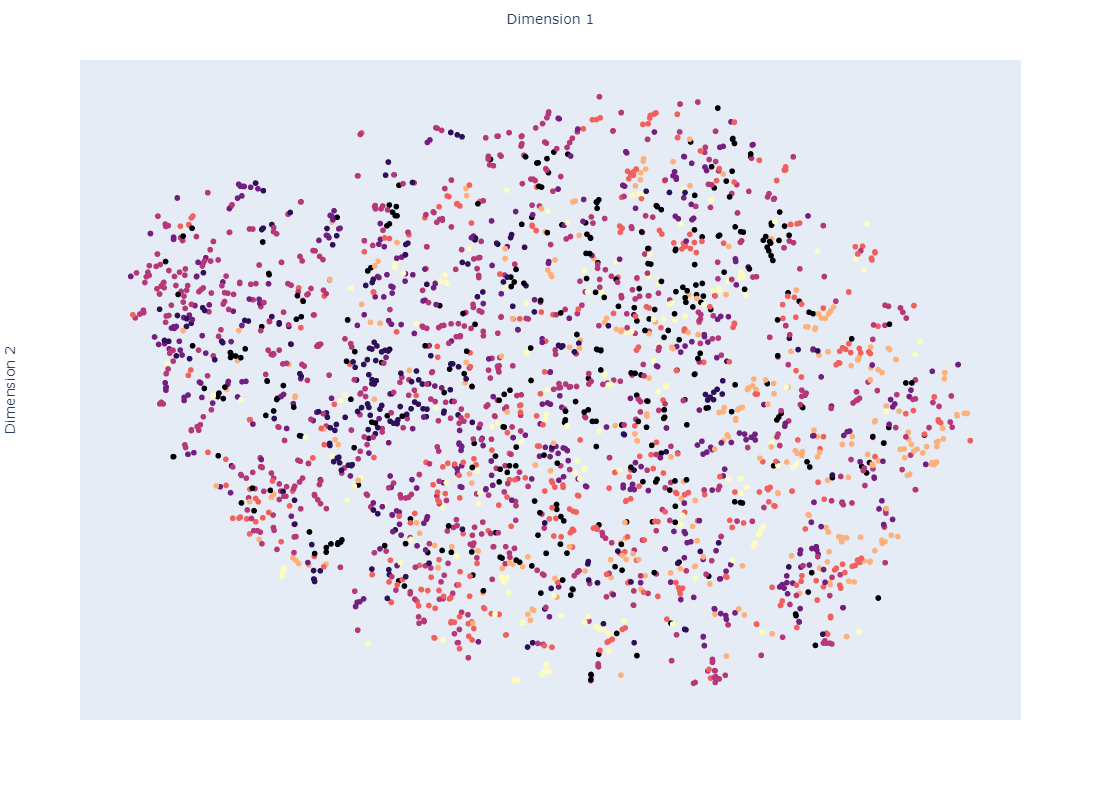

Save in plotly successfully


In [52]:
model.eval()

out = model(data.x, data.edge_index)
visualize_2d(out, color=data.y, name = 'not_trained_2d_dist_plot')

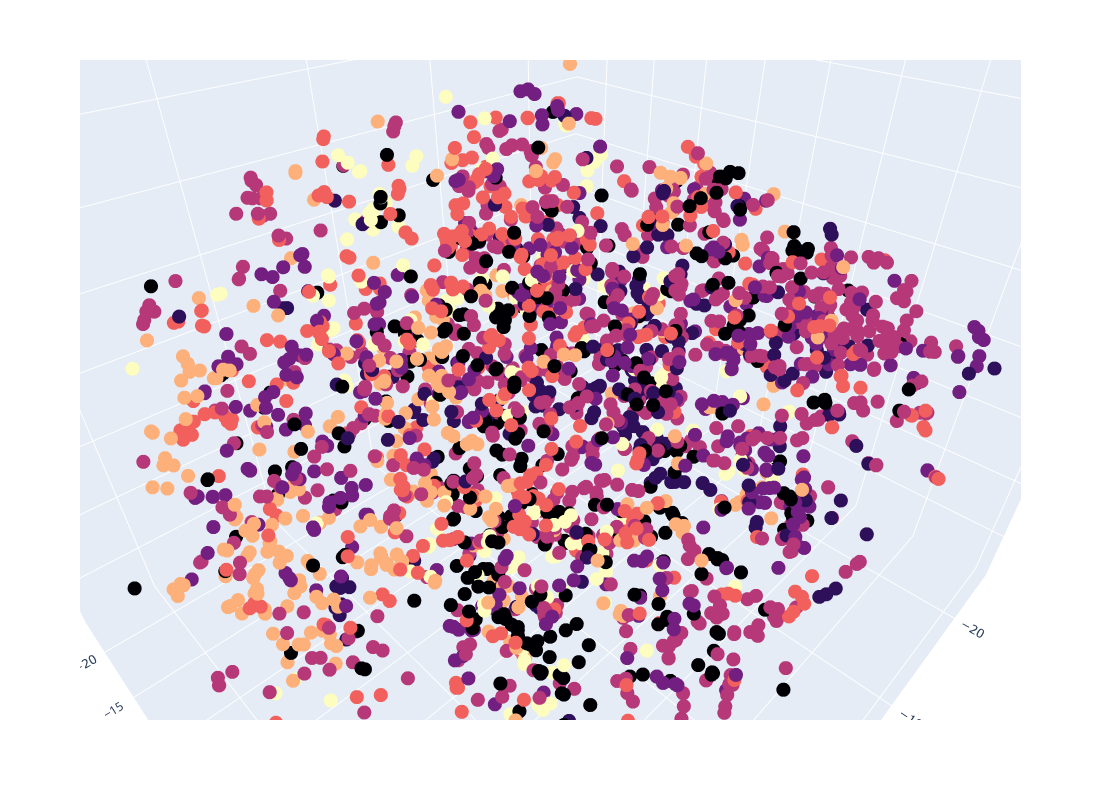

Save in plotly successfully


In [39]:
visualize_3d(out, color=data.y, name = 'non_trained_3d_plot')

## Training and Visualization

Epoch: 001, Loss: 1.9463, Test Acc: 0.2700
Epoch: 002, Loss: 1.9409, Test Acc: 0.2910
Epoch: 003, Loss: 1.9343, Test Acc: 0.2910
Epoch: 004, Loss: 1.9275, Test Acc: 0.3210
Epoch: 005, Loss: 1.9181, Test Acc: 0.3630
Epoch: 006, Loss: 1.9086, Test Acc: 0.4120
Epoch: 007, Loss: 1.9015, Test Acc: 0.4010
Epoch: 008, Loss: 1.8933, Test Acc: 0.4020
Epoch: 009, Loss: 1.8808, Test Acc: 0.4180
Epoch: 010, Loss: 1.8685, Test Acc: 0.4470
Epoch: 011, Loss: 1.8598, Test Acc: 0.4680
Epoch: 012, Loss: 1.8482, Test Acc: 0.5180
Epoch: 013, Loss: 1.8290, Test Acc: 0.5440
Epoch: 014, Loss: 1.8233, Test Acc: 0.5720
Epoch: 015, Loss: 1.8057, Test Acc: 0.5910
Epoch: 016, Loss: 1.7966, Test Acc: 0.6080
Epoch: 017, Loss: 1.7825, Test Acc: 0.6300
Epoch: 018, Loss: 1.7617, Test Acc: 0.6450
Epoch: 019, Loss: 1.7491, Test Acc: 0.6520
Epoch: 020, Loss: 1.7310, Test Acc: 0.6560
Epoch: 021, Loss: 1.7147, Test Acc: 0.6570
Epoch: 022, Loss: 1.7056, Test Acc: 0.6640
Epoch: 023, Loss: 1.6954, Test Acc: 0.6770
Epoch: 024,

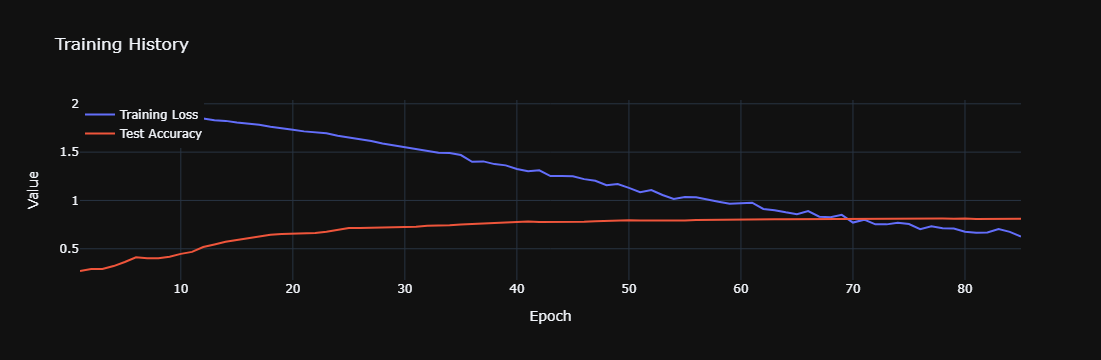

Save in plotly successfully


In [58]:
model = GCN(hidden_channels=16)

built_model = BuildModel(model)
history  = built_model.train_with_early_stopping(plot = True, plot_name="gcn_history_plot")

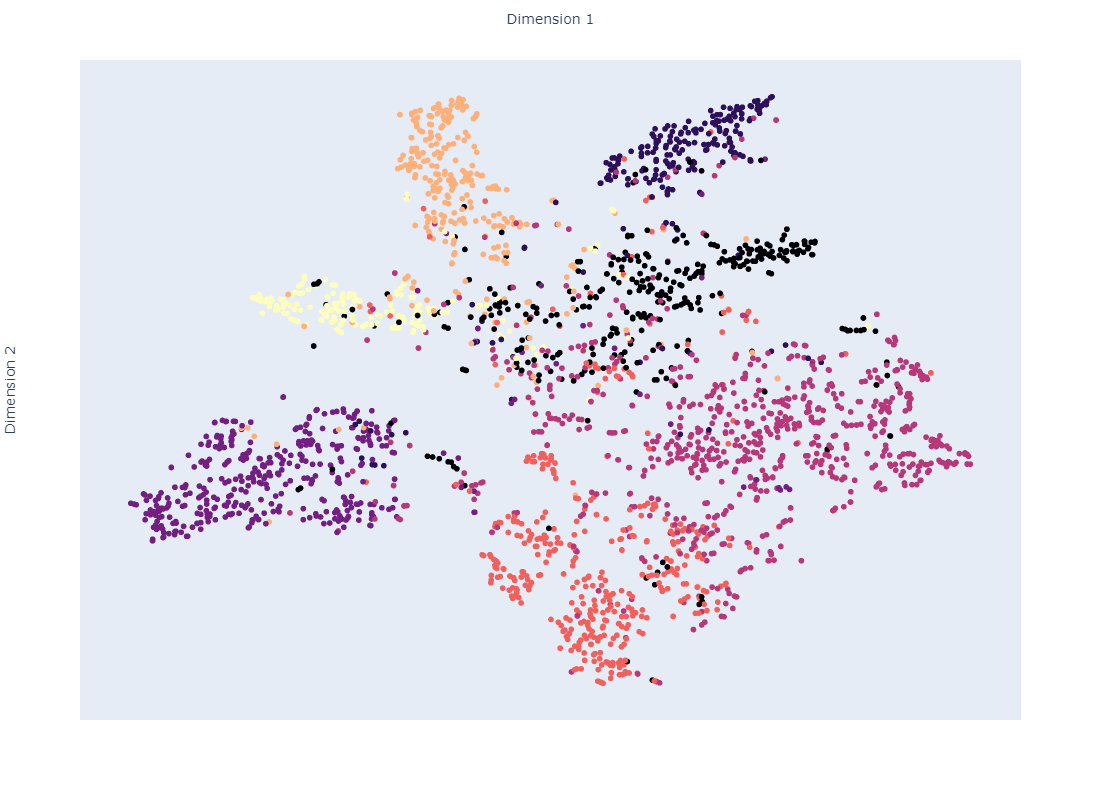

Save in plotly successfully


In [44]:
model.eval()
out = model(data.x, data.edge_index)
visualize_2d(out, color=data.y, name = 'gcn_plot_2d')

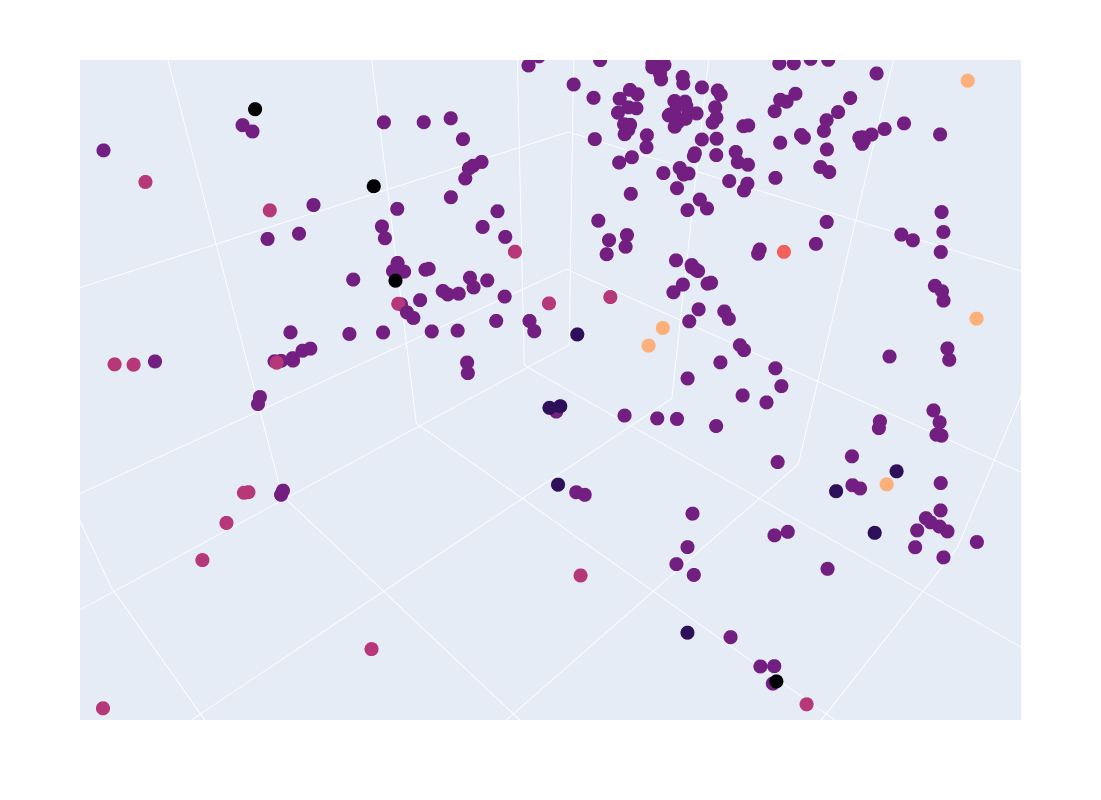

Save in plotly successfully


In [45]:
visualize_3d(out, color=data.y, name = 'gcn_3d_plot')

# GAT

## Build Model

In [53]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)


## Training and Visalization

Epoch: 001, Loss: 0.6564, Test Acc: 0.7780
Epoch: 002, Loss: 0.6479, Test Acc: 0.7780
Epoch: 003, Loss: 0.6208, Test Acc: 0.8100
Epoch: 004, Loss: 0.5841, Test Acc: 0.8180
Epoch: 005, Loss: 0.5878, Test Acc: 0.8170
Epoch: 006, Loss: 0.5477, Test Acc: 0.8060
Epoch: 007, Loss: 0.4723, Test Acc: 0.7950
Epoch: 008, Loss: 0.4452, Test Acc: 0.8000
Epoch: 009, Loss: 0.4338, Test Acc: 0.8070
Epoch: 010, Loss: 0.4332, Test Acc: 0.8100
Epoch: 011, Loss: 0.4218, Test Acc: 0.8150
Epoch: 012, Loss: 0.3900, Test Acc: 0.8150
Epoch: 013, Loss: 0.4190, Test Acc: 0.8160
Epoch: 014, Loss: 0.4238, Test Acc: 0.8080
Early stopping triggered at epoch 14.


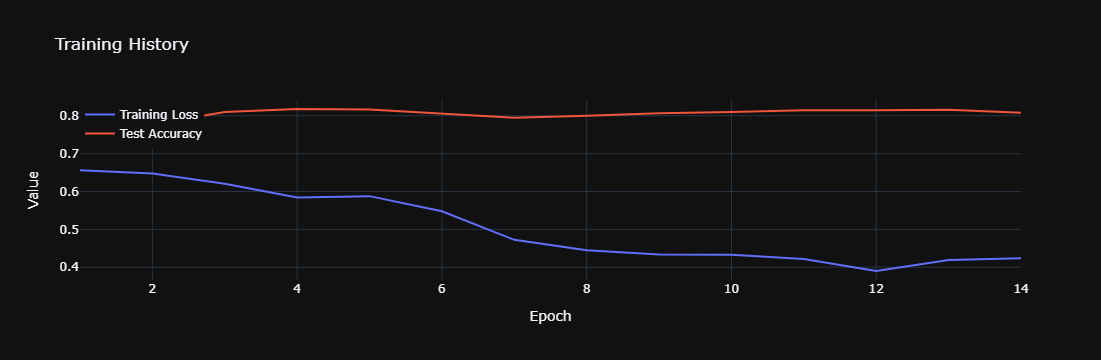

Save in plotly successfully


In [59]:
buildGANModel = BuildModel(model, lr = 0.05)
history = buildGANModel.train_with_early_stopping(plot = True, plot_name = 'gat_history_plot')

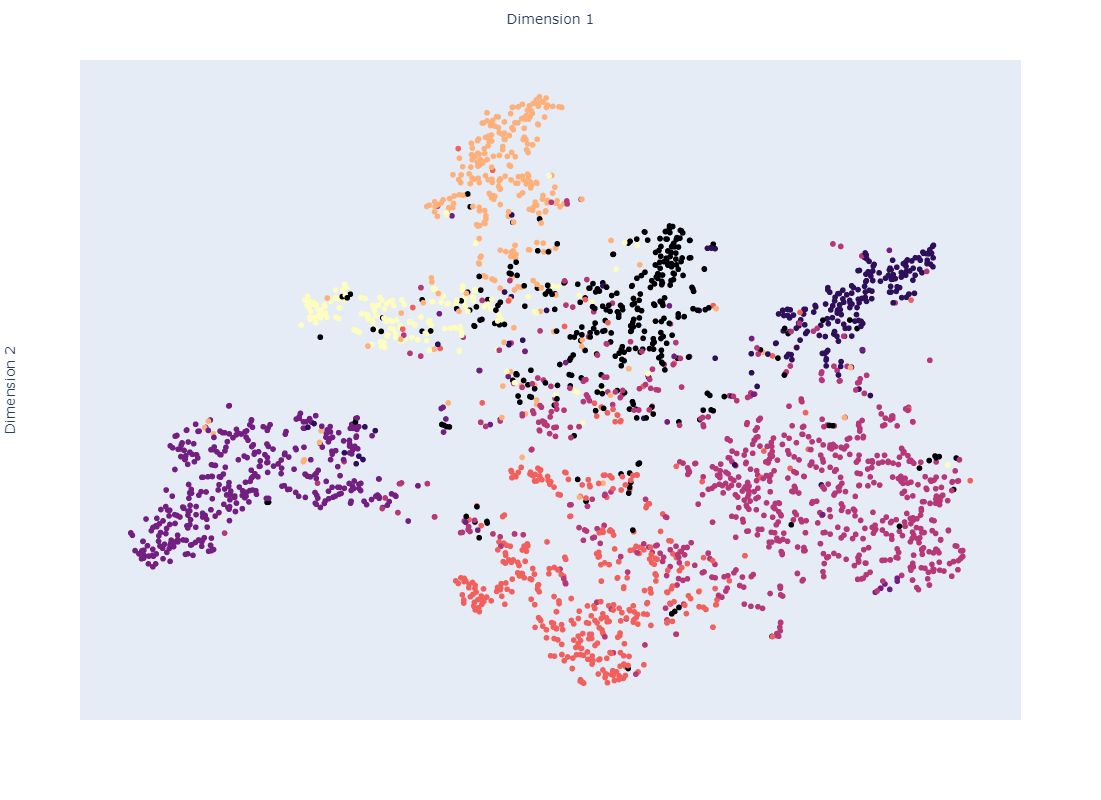

Save in plotly successfully


In [60]:
model.eval()
out = model(data.x, data.edge_index)
visualize_2d(out, color=data.y, name = 'gat_2d_dist_plot')

In [62]:
visualize_3d(out, color=data.y, name = 'gat_3d_dist_plot')

Save in plotly successfully


## Stay committed and dedicated :)